#### Thomas Mallinson - IMSE 785 - Project 5

In [ ]:
# Loading data
df = spark.read.format("csv").option("inferscema", "true").load("/FileStore/tables/crimes.csv") 
df.show(1)

+-----------+------------+
 _c0| _c1|
+-----------+------------+
41.85118101|-87.70538082|
+-----------+------------+
only showing top 1 row

In [ ]:
# It seems like newer versions of spark prefer using the pyspark.ml library instead of the rdd-based mlib. MLib is becoming deprecated
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# changing data types to float
df1 = df.withColumn('_c0', df['_c0'].cast('float'))
df1 = df1.withColumn('_c1', df['_c1'].cast('float'))
df1.printSchema()

# assemble features
vecAssembler = VectorAssembler(inputCols=["_c0", "_c1"], outputCol="features")
new_df = vecAssembler.transform(df1)
new_df.show(5)

root
-- _c0: float (nullable = true)
-- _c1: float (nullable = true)

+---------+---------+--------------------+
 _c0| _c1| features|
+---------+---------+--------------------+
 41.85118|-87.70538|[41.8511810302734...|
41.878998|-87.72429|[41.8789978027343...|
41.904835|-87.75795|[41.9048347473144...|
 41.88364|-87.76038|[41.8836402893066...|
 41.88364|-87.76038|[41.8836402893066...|
+---------+---------+--------------------+
only showing top 5 rows

In [ ]:
# 1. Split the dataset into 80/20 train/test datasets. Report the number of points for each dataset. Each row represents the location of a crime scene in Chicago areas.
(trainingData, testData) = new_df.randomSplit([0.8, 0.2], seed=100)
print("Training data count is:", trainingData.count())
print("Test data count is:", testData.count())

Training data count is: 833900
Test data count is: 208574

Silhouette Score: 0.7205491503041752
Silhouette Score: 0.608989481696515
Silhouette Score: 0.5268277160718198
Silhouette Score: 0.5340370464184336
Silhouette Score: 0.5539310641465923
Silhouette Score: 0.5352998792000959
Silhouette Score: 0.5094965667544492
Silhouette Score: 0.504343545220339
Out[45]:

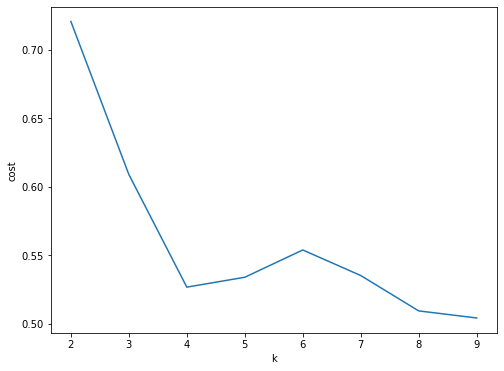

Text(0, 0.5, 'cost')

In [ ]:
# 2. Build a K-means model using the training dataset. Report the cluster centers. Plot them on Google Maps. How many clusters provide the best fits in terms of MSE?
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Visualizing the silhouette score
silhouette_score = []

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='features', k=i)
    KMeans_fit=KMeans_algo.fit(trainingData)   
    output=KMeans_fit.transform(trainingData)
    score=evaluator.evaluate(output)   
    silhouette_score.append(score)   
    print("Silhouette Score:",score)
    
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")

In [ ]:
# Setting k = 6 where a local maxima of Silhouette Score is observed and training a model
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(trainingData)

# Make predictions
predictions = model.transform(trainingData)

# Results of cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
  print(center)

Cluster Centers: 
[ 41.77747941 -87.67846542]
[ 41.96356674 -87.67842263]
[ 41.73647482 -87.60281991]
[ 41.94586536 -87.77935693]
[ 41.87255811 -87.63924834]
[ 41.88312852 -87.72590454]

In [ ]:
# 3. Classify each point in the testing dataset based on the fitted cluster centers. Report the numbers of points classified into each center and its corresponding MSE. 
# Use two pie charts to convey the same information (training and testing). Draw conclusions about the model performance

# Dataframe for trainingData model
train_df = model.transform(trainingData)

# Dataframe for testData
predict_df = model.transform(testData)

# Count number in each cluster
train_df.groupBy("prediction").count().show()
predict_df.groupBy("prediction").count().show()

+----------+------+
prediction| count|
+----------+------+
 1|106843|
 3| 61512|
 5|178468|
 4|127274|
 2|197505|
 0|162298|
+----------+------+

+----------+-----+
prediction|count|
+----------+-----+
 1|26953|
 3|15281|
 5|44374|
 4|31851|
 2|49757|
 0|40358|
+----------+-----+

In [ ]:
# Visualizing counts with pie charts
display(train_df.groupBy("prediction").count())

prediction,count
1,106843
3,61512
5,178468
4,127274
2,197505
0,162298


In [ ]:
display(predict_df.groupBy("prediction").count())

prediction,count
1,26953
3,15281
5,44374
4,31851
2,49757
0,40358


Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified.

In [ ]:
# Silhoutte score instead of utilizing MSE (better suited for interpretation and validation of consistency within clusters of data)
silhouette = evaluator.evaluate(predict_df)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5699839107090422

When analyzing the pie charts and distribution of points within clusters, the % breakdown is identical for both the training and testing data when rounded to a whole %. This indicates that our model is very strong in classifying the test data into the correct clusters.

### 4. Can this clustering information help Chicago PD or politicians make informed decisions? Discuss?

Yes, the information from this modeling could be presented to these audiences in order to help aid them where to focus their concentrations. Police may find it useful to patrol these areas to increase their probabilities in preventing crimes. Politicians may like to know where these areas are to implement strategies to help or attempt to slow the crime rates down.